In [165]:
# Setup - Datasets
from IPython.display import Markdown
import jupyter_black
import pandas as pd
import numpy as np

jupyter_black.load()

LABELS = np.array(["for respondent", "for petitioner"])


# Loading dataframes
from supreme_court_predictions.util.functions import get_full_data_pathway

# Loading unprocessed dataframes
data_path = get_full_data_pathway("clean_convokit/")
utterances = pd.read_csv(data_path + "utterances_df.csv")
advocates = pd.read_csv(data_path + "advocates_df.csv")
cases = pd.read_csv(data_path + "cases_df.csv")
conversations = pd.read_csv(data_path + "conversations_df.csv")
speakers = pd.read_csv(data_path + "speakers_df.csv")
voters = pd.read_csv(data_path + "voters_df.csv")

# Loading processed dataframes
proc_data_path = get_full_data_pathway("processed/")
cases_proc = pd.read_pickle(proc_data_path + "case_aggregations.p")
judges_proc = pd.read_pickle(proc_data_path + "judge_aggregations.p")
adversary_proc = pd.read_pickle(proc_data_path + "adversary_aggregations.p")
advocate_proc = pd.read_pickle(proc_data_path + "advocate_aggregations.p")

# Loading descriptive statistics
from supreme_court_predictions.summary_analysis.descriptive_statistics import (
    DescriptiveStatistics,
)

ds = DescriptiveStatistics()
ds.parse_all_data()

In [194]:
# Setup - Models and plots
# Load models
from supreme_court_predictions.models.logistic_regression import (
    LogisticRegression,
)
from supreme_court_predictions.models.random_forest import RandomForest
from supreme_court_predictions.models.xg_boost import XGBoost

lr = LogisticRegression()
lr.run()

rf = RandomForest()
rf.run()

xg = XGBoost()
xg.run()

# Model Comparison DF - using advocate utterances
models = [
    "logistic regression",
    "random forest",
]  # TODO - add xg boost when possible
accuracy = [
    lr.accuracies["adversary_aggregations"],
    rf.accuracies["adversary_aggregations"],
]  # TODO - add xg boost when possible
f1 = [
    lr.f1["adversary_aggregations"],
    rf.f1["adversary_aggregations"],
]  # TODO - add xg boost when possible

model_comp = {"model": models, "accuracy": accuracy, "f1_score": f1}
model_comp = pd.DataFrame.from_dict(model_comp)


# Setup for plots
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

In [167]:
# Helper Functions
def dict_to_df(column_names, dict1, dict2=None):
    """
    Transforms a dictionary to a dataframe for better presentation.

    :param column_names (list): List of column names for dataframe.
    :param dict1 (dictionary): Dictionary of data to convert.
    :param dict1 (dictionary, optional): Dictionary of data to convert.
    : return (DataFrame) DataFrame representation of dictionary.
    """

    df = {}
    df[column_names[0]] = list(dict1.keys())
    df[column_names[1]] = list(dict1.values())

    if dict2 != None:
        df[column_names[2]] = list(dict2.values())

    df = pd.DataFrame.from_dict(df)

    return df


def disp_accuracy(df, labs, x_label="Dataset"):
    """
    Creates a barchart representing the accuracy and f1 scores of a dataset.

    :param df (DataFrame) Dataframe with three columns: dataset name, accuracy
                          score, and F1 score.
    """
    # set width of bar
    barWidth = 0.25
    fig = plt.subplots(figsize=(12, 8))

    # set height of bar
    accs = list(df["accuracy"])
    f1 = list(df["f1_score"])

    # Set position of bar on X axis
    br1 = np.arange(len(df))
    br2 = [x + barWidth for x in br1]

    # Make the plot
    plt.bar(
        br1,
        accs,
        color="gray",
        width=barWidth,
        edgecolor="grey",
        label="Accuracy",
    )
    plt.bar(
        br2,
        f1,
        color="blue",
        width=barWidth,
        edgecolor="grey",
        label="F1 Score",
    )

    # Adding Xticks
    plt.xlabel(x_label, fontweight="bold", fontsize=15)
    plt.ylabel("Prop Correct Prediction", fontweight="bold", fontsize=15)
    plt.xticks(
        [r + barWidth for r in range(len(accs))],
        labs,
    )

    plt.legend()
    plt.show()


def disp_conf_matrix(cm):
    """
    Creates a plot of the confusion matrix.

    :param cm (array): Confusion matrix to display.
    """
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=LABELS,
    )
    disp.plot()
    plt.show()

## Machine Learning Final Presentation
### Predicting Outcomes of US Supreme Court Oral Arguments
**Team Members: Federico Dominguez, Chanteria Milner, Jessup Jong, Michael Plunkett**

## Background
- <b>Dataset</b>: Supreme Court Oral Arguments Corpus
- <b>Souce</b>: Court transcripts from [oyez.org](https://www.oyez.org/), voting information from [Supreme Court Dataset](http://scdb.wustl.edu/index.php)
- <b>Goal</b>: Predict case decision using case transcripts and NLP models


## Datasets
### Six total datasets
1. Cases
2. Speakers
3. Voters
4. Advocates
5. Conversations
6. Utterances


### Case Information
Includes infromation on each <i>court case</i>, such as:
- Unique case ID
- Year and title of case
- Case petitioner and respondent
- Winning side (1 = for petitioner) and decision date

In [168]:
ds.cases_stats

counts  percentages
win side             for petitioner   284.0    66.510539
                     for respondent   143.0    33.489461
cases                                 427.0          NaN
courts                                  1.0          NaN
years (2014 to 2019)                    6.0          NaN
petitioners                           413.0          NaN
respondents                           356.0          NaN

### Speakers
Includes infromation on each <i>speaker</i>, such as:
- Speaker name and unique speaker key
- Speaker role and type (justice, advocate, nan)

In [169]:
ds.speakers_stats

counts  percentages
speaker type  advocate (A)  8942.0    99.610115
              justice (J)     35.0     0.389885
speaker names               8928.0          NaN
speaker keys                8977.0          NaN

### Voters
Includes infromation on each <i>vote and voter</i>, such as:
- Unique case ID
- Voter key and vote side (judges only, 1=for petitioner)

In [170]:
ds.voters_stats.head(7)

counts percentages
votes    for petitioner        1912.0   60.659898
         for respondent        1240.0   39.340102
justices                         11.0         NaN
justice  j__john_g_roberts_jr     363    0.661157
         j__antonin_scalia         66    0.651515
         j__anthony_m_kennedy     240    0.658333
         j__clarence_thomas       364    0.532967

### Advocates
Includes infromation on each <i>advocate (non-judges)</i>, such as:
- Unique case ID
- Advocate ID and advocacy side(1 = for petitioner)
- Advocate role

In [171]:
ds.advocates_stats

counts  percentages
side            for petitioner   403.0    50.124378
                for respondent   401.0    49.875622
total advocates                  391.0          NaN
total roles                      154.0          NaN
aggregate roles inferred          10.0     1.243781
                for respondent   404.0    50.248756
                for petitioner   390.0    48.507463

### Conversations
Includes infromation on each <i>conversation</i>. There is one conversation per case, <br>
and conversations are made up of individual utterances. Conversation information includes:

- Unique case ID
- Unique conversation ID
- Winning side (1 = for petitioner)

In [172]:
conversations.head(2)

,id,case_id,winning_side
0,23291,2014_13-553,1
1,23252,2014_13-895,1


### Utterances
Includes infromation on each <i>utterance</i>, such as:
- Unique case ID
- Corresponding conversation ID
- Speaker key
- Utterance text

In [173]:
cols = ["case_id", "speaker", "speaker_type", "conversation_id", "text"]

In [174]:
utterances.head(2).loc[:, cols]

,case_id,speaker,speaker_type,conversation_id,text
0,2014_13-553,j__john_g_roberts_jr,J,23291,"we'll hear argument next in case no. 13-553, t..."
1,2014_13-553,andrew_l_brasher,A,23291,"thank you, mr. chief justice, and may it pleas..."


## Data Cleaning and Pre-Processing
### Data Cleaning Steps:
1. Limited cases to those that ruled either for the petitioner or respondent (removed undetermined)
2. Removed cases with no utterances
3. Cleaned utterance text
4. Filtered cases to include last 5 years of dataset (2014-2019)


### Data Processing Steps
1. Tokenized utterance text
2. Created utterances dataframes that includes tokenized text, case id, year, and winning side. These dataframes corresponded to:
    -  All utterances within a case
    - Judge utterances within a case
    - Advocate (for petitioner) utterances within a case
    - Adversary (for respondent) utterances within a case

## Pre-processed Datasets
### All Utterances

In [175]:
cases_proc.head(2)

,case_id,tokens,avg_num_sentences,avg_num_words,year,win_side
0,2014_13-553,"[hear, argument, case, alabama, department, re...",2.447368,178.478947,2014,1
1,2014_13-895,"[hear, argument, case, number, alabama, legisl...",2.432203,184.368644,2014,1


### Judge Utterances
In addition to standard columns, includes columns on count of advocates for petitioner or respondent.

In [176]:
judges_proc.head(2)

,case_id,tokens,avg_num_sentences,avg_num_words,year,win_side
0,2014_13-553,"[hear, argument, case, alabama, department, re...",1.682692,94.5000,2014,1
1,2014_13-895,"[hear, argument, case, number, alabama, legisl...",2.039062,132.9375,2014,1


### Advocate Utterances

In [177]:
advocate_proc.head(2)

,case_id,tokens,avg_num_sentences,avg_num_words,year,win_side
0,2014_13-553,"[hear, argument, case, alabama, department, re...",2.212329,163.547945,2014,1
1,2014_13-895,"[mr, chief, justice, court, alabama, employ, r...",2.326241,164.439716,2014,1


### Adversary Utterances

In [178]:
adversary_proc.head(2)

,case_id,tokens,avg_num_sentences,avg_num_words,year,win_side
0,2014_13-553,"[handpicked, business, transport, good, motor,...",3.227273,228.022727,2014,1
1,2014_13-895,"[hear, argument, case, number, alabama, legisl...",2.589474,213.947368,2014,1


## Model and Evaulation Overviews
- Logistic Regression
- Gradient Boosted Tree Model
- Random Forest

### Logistic Regression
<span style="color:red"><b>[insert description]</b></span>

### Gradient Boosted Tree Model
<span style="color:red"><b>[insert description]</b></span>

### Random Forest
<span style="color:red"><b>[insert description]</b></span>

### Evaluation Metrics: Accuracy and F1 Score

In [179]:
ds.cases_stats.head(2)

counts  percentages
win side for petitioner   284.0    66.510539
         for respondent   143.0    33.489461

<span style="color:red"><b>[insert explanation for accuracy]</b></span>

<span style="color:red"><b>[insert explanation for f1 score]</b></span>

The majority (approximately 67%) of cases were voted in favor of the petitioner (win_side=1)

## Logistic Regression
### Default Parameters

- **Maximum number of featuers**: 5000
- **Maximum number of iterations**: 1000
- **Test size**: 0.20

### Accuracies and F1 Score

In [180]:
acc = dict_to_df(["dataset", "accuracy", "f1_score"], lr.accuracies, lr.f1)
acc

,dataset,accuracy,f1_score
0,case_aggregations,0.540541,0.653061
1,judge_aggregations,0.520548,0.646465
2,advocate_aggregations,0.756757,0.808511
3,adversary_aggregations,0.783784,0.843137


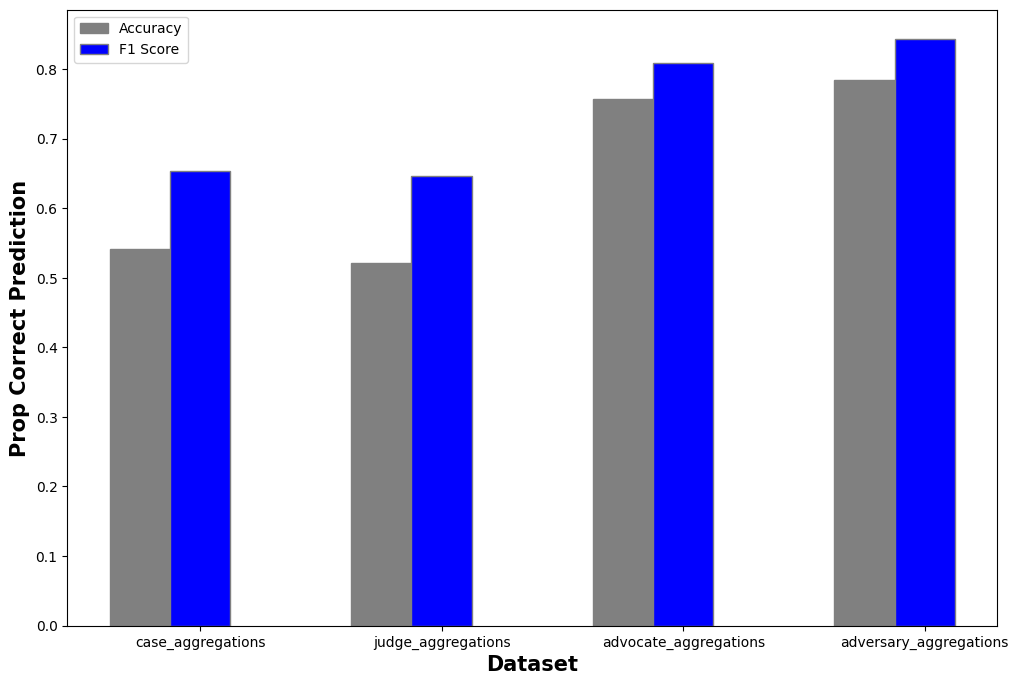

In [181]:
disp_accuracy(acc, labs=list(acc["dataset"]))

### Confusion Matrices
#### Logistic Regression Model - All Utterances

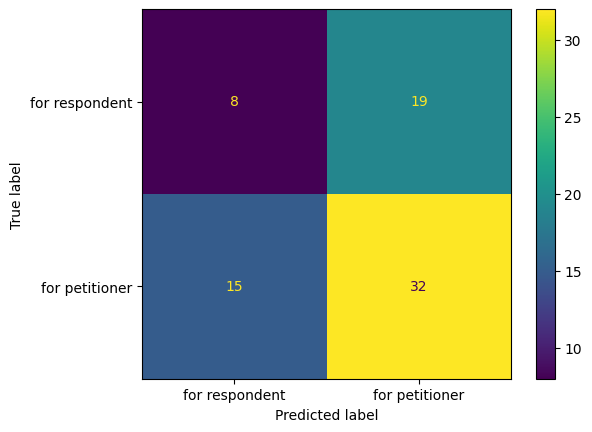

In [182]:
disp_conf_matrix(lr.confusion_matrix["case_aggregations"])

#### Logistic Regression Model - Judge Utterances

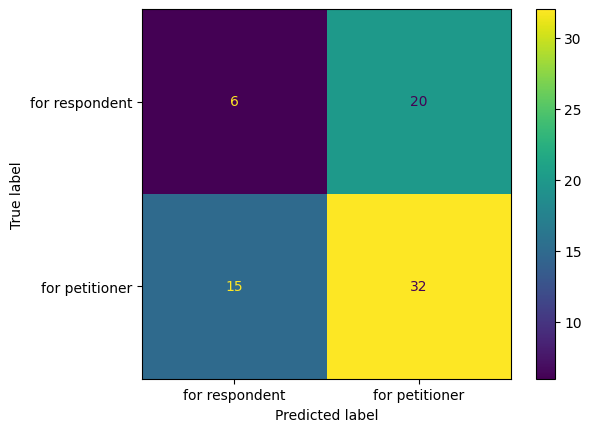

In [183]:
disp_conf_matrix(lr.confusion_matrix["judge_aggregations"])

#### Logistic Regression Model - Advocate Utterances

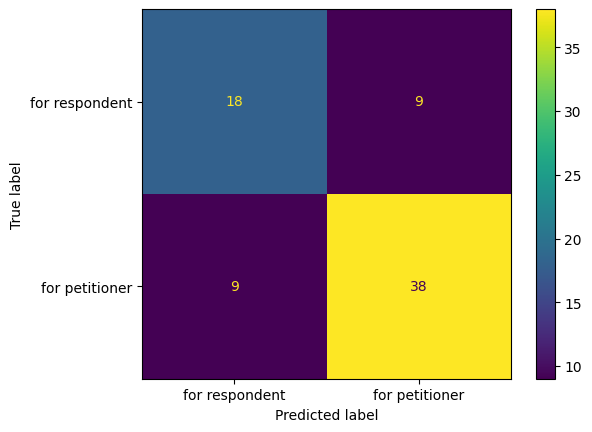

In [184]:
disp_conf_matrix(lr.confusion_matrix["advocate_aggregations"])

#### Logistic Regression Model - Adversary Utterances

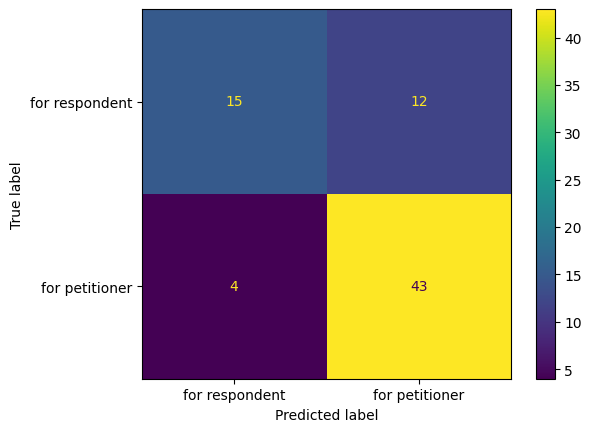

In [185]:
disp_conf_matrix(lr.confusion_matrix["adversary_aggregations"])

### Hyperparameter Tuning

<span style="color:red"><b>[insert plots]</b></span>

## Random Forest
### Default Parameters

- **Maximum Depth**: None
- **Maximum Features**: 5000
- **Number of trees**: 100
- **Test Size**: 0.20

### Accuracies and F1 Score

In [151]:
acc = dict_to_df(["dataset", "accuracy", "f1_score"], rf.accuracies, rf.f1)
acc

,dataset,accuracy,f1_score
0,case_aggregations,0.621622,0.766667
1,judge_aggregations,0.643836,0.783333
2,advocate_aggregations,0.824324,0.876190
3,adversary_aggregations,0.810811,0.860000


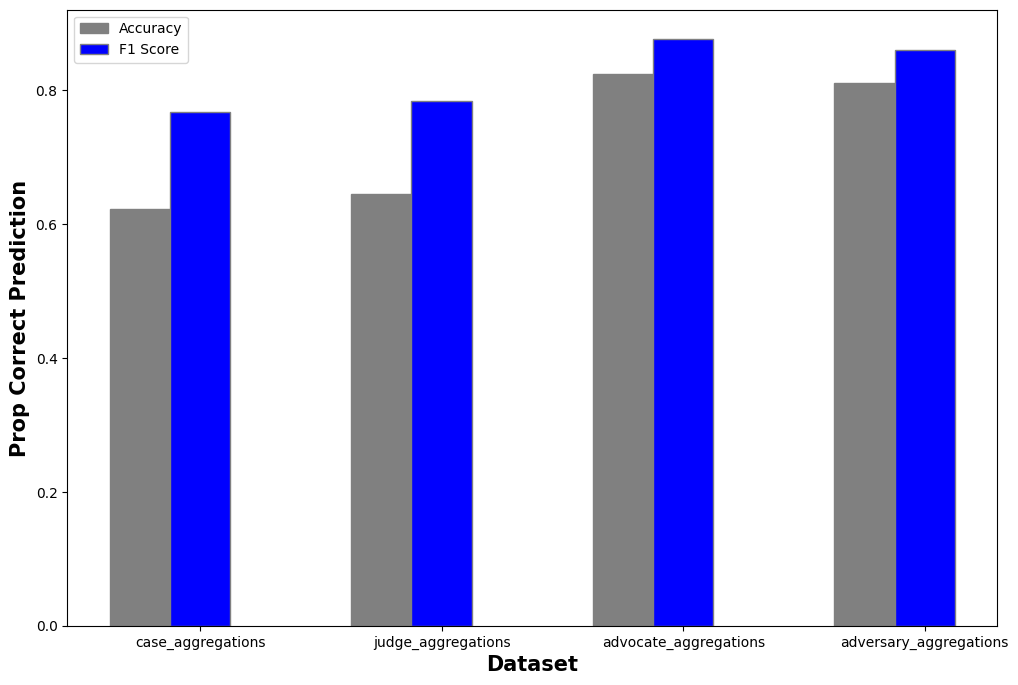

In [152]:
disp_accuracy(acc, labs=acc["dataset"])

### Confusion Matrices
#### Random Forest Model - All Utterances

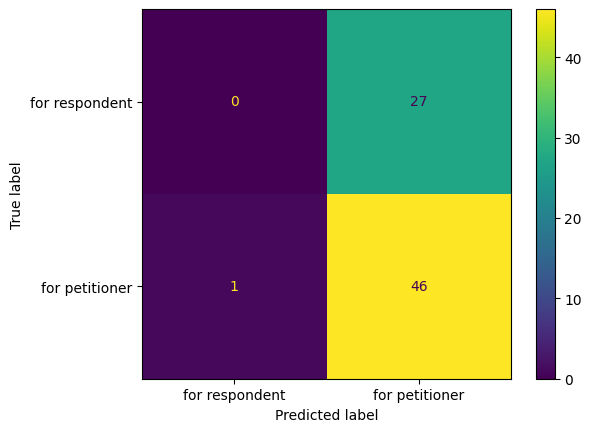

In [153]:
disp_conf_matrix(rf.confusion_matrix["case_aggregations"])

#### Random Forest Model - Judge Utterances

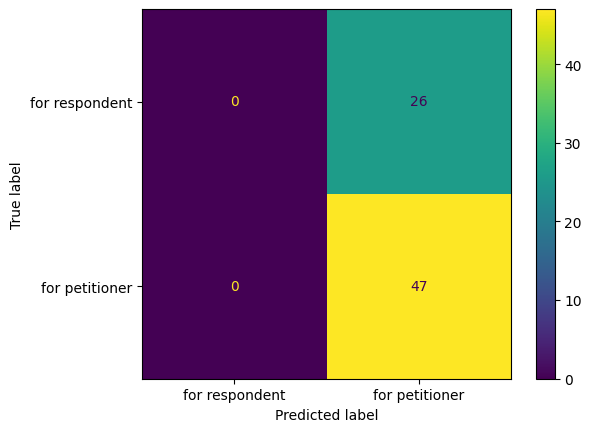

In [154]:
disp_conf_matrix(rf.confusion_matrix["judge_aggregations"])

#### Random Forest Model - Advocate Utterances

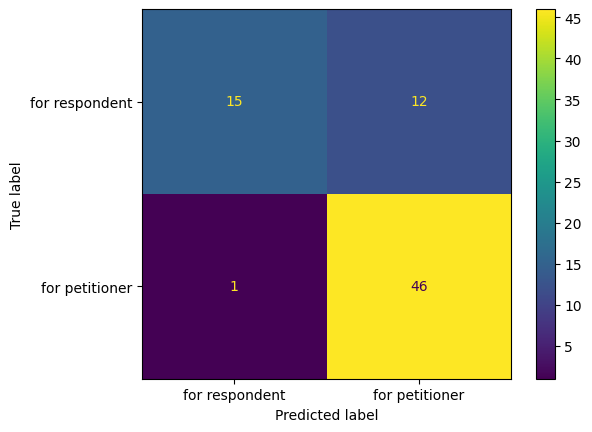

In [155]:
disp_conf_matrix(rf.confusion_matrix["advocate_aggregations"])

#### Random Forest Model - Adversary Utterances

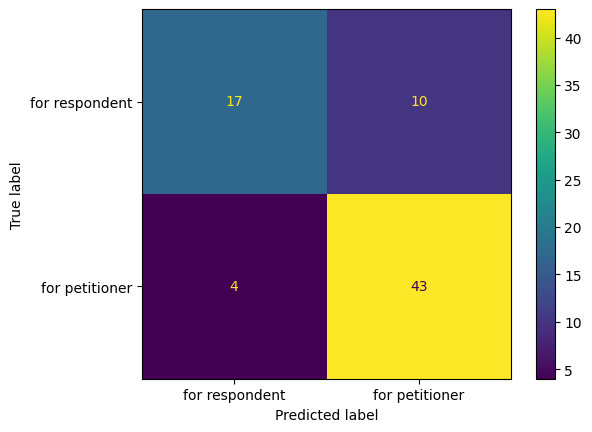

In [156]:
disp_conf_matrix(rf.confusion_matrix["adversary_aggregations"])

### Hyperparameter Tuning

<span style="color:red"><b>[insert plots]</b></span>

## Gradient Boosted Tree - cannot do right now
### Default Parameters

- **Maximum number of features**: 5000
- **Test size**: 0.20
- **Maximum depth**: 7
- **Number of estimators**: 100
- **Learning rate**: 0.3
- **Subsample**: 1

### Accuracies and F1 Score

In [ ]:
acc = dict_to_df(["dataset", "accuracy", "f1_score"], xg.accuracies, xg.f1)
acc

In [ ]:
disp_accuracy(acc)

### Confusion Matrices
#### Gradient Boosted Tree Model - All Utterances

In [ ]:
disp_conf_matrix(xg.confusion_matrix["case_aggregations"])

#### Gradient Boosted Tree Model - Judge Utterances

In [ ]:
disp_conf_matrix(xg.confusion_matrix["judge_aggregations"])

#### Gradient Boosted Tree Model - Advocate Utterances

In [ ]:
disp_conf_matrix(xg.confusion_matrix["advocate_aggregations"])

#### Gradient Boosted Tree Model - Adversary Utterances

In [ ]:
disp_conf_matrix(xg.confusion_matrix["adversary_aggregations"])

### Hyperparameter Tuning

<span style="color:red"><b>[insert plots]</b></span>

## Model Comparisons
Using the advocate utterances dataframe as a case study

In [195]:
model_comp

,model,accuracy,f1_score
0,logistic regression,0.783784,0.843137
1,random forest,0.810811,0.860000


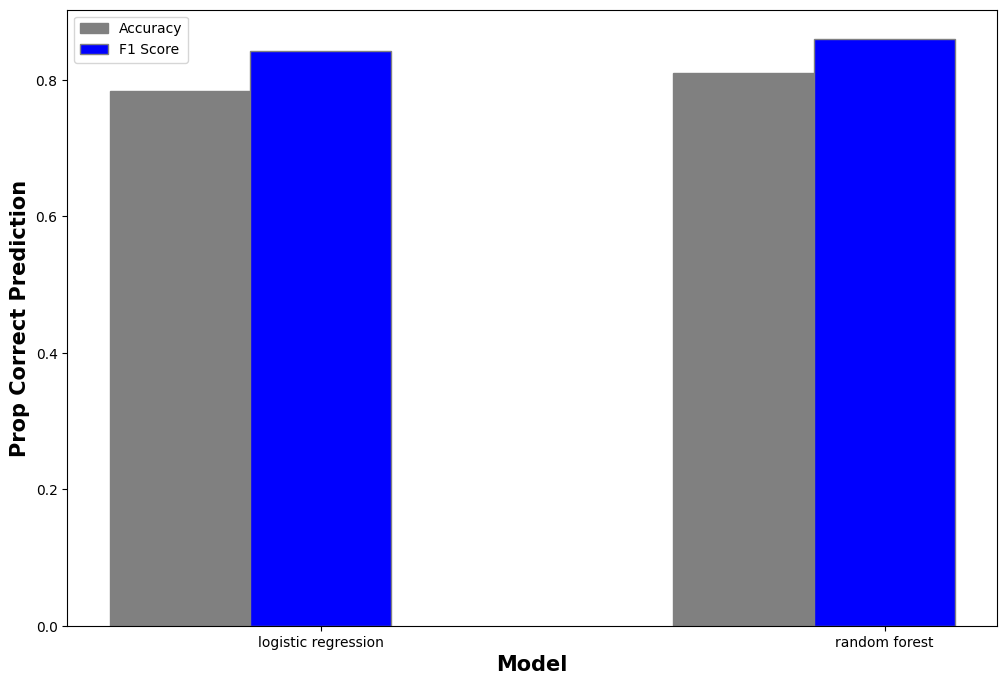

In [196]:
disp_accuracy(model_comp, labs=model_comp["model"], x_label="Model")

## Final Thoughts and Applications

<span style="color:red"><b>[insert]</b></span>

## Thank you!
### Any Questions?